In [59]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyamitis.amitis_particle import *

case = "RPS_Base"
main_path = f'/Volumes/data_backup/mercury/extreme/{case}/05/'
output_folder = f"/Users/danywaller/Projects/mercury/extreme/surface_flux/"

specie_id = 0  # Pick which species to plot
species = np.array(['H+', 'He++'])  # The order is important and it should be based on Amitis.inp file
sim_ppc = [24, 11]  # Number of particles per species, based on Amitis.inp
sim_den = [38.0e6, 1.0e6]
sim_vel = [400.e3, 400.e3]

sim_dx = 75.e3  # simulation cell size based on Amitis.inp
sim_dy = 75.e3  # simulation cell size based on Amitis.inp
sim_dz = 75.e3  # simulation cell size based on Amitis.inp
sim_robs = 2440.e3  # obstacle radius based on Amitis.inp

select_R = 2480.e3  # the radius of a sphere + 1/2 grid cell above the surface for particle selection
dphi = 2.  # delta_phi   [0, 360] deg
dtheta = 2.  # delta_theta [0, 180] deg

sub_filepath = main_path + 'particles/'
sub_filename = f'Subset_{case}'

if "CP" in case:
    input_folder2 = f"/Users/danywaller/Projects/mercury/extreme/bfield_topology/{case}_largerxdomain_smallergridsize/"
    csv_file = os.path.join(input_folder2, f"{case}_largerxdomain_smallergridsize_115000_ocb_curve.csv")  # single timestep CSV with OCB curve

    # Load footprint CSV
    if os.path.exists(csv_file):
        df_footprints = pd.read_csv(csv_file)
        print(f"Loaded {len(df_footprints)} footprints for {case}")

all_particles_directory = main_path + 'precipitation/'
os.makedirs(all_particles_directory, exist_ok=True)
moments_filename = all_particles_directory + "moments"


In [60]:
with np.load(moments_filename + "_" + species[specie_id] + ".npz") as data:
    cnts   = data["cnts"]
    den    = data["den"]
    velr   = data["velr"]
    flxr   = data["flxr"]
    dphi   = data["dphi"]
    dtheta = data["dtheta"]

print(f"Loaded {len(cnts)} moments for {case.replace("_", " ")} {species[specie_id]}")

Loaded 180 moments for RPS Base H+


Saved figure: /Users/danywaller/Projects/mercury/extreme/surface_flux/RPS_Base_H+_new_surface_flux.png


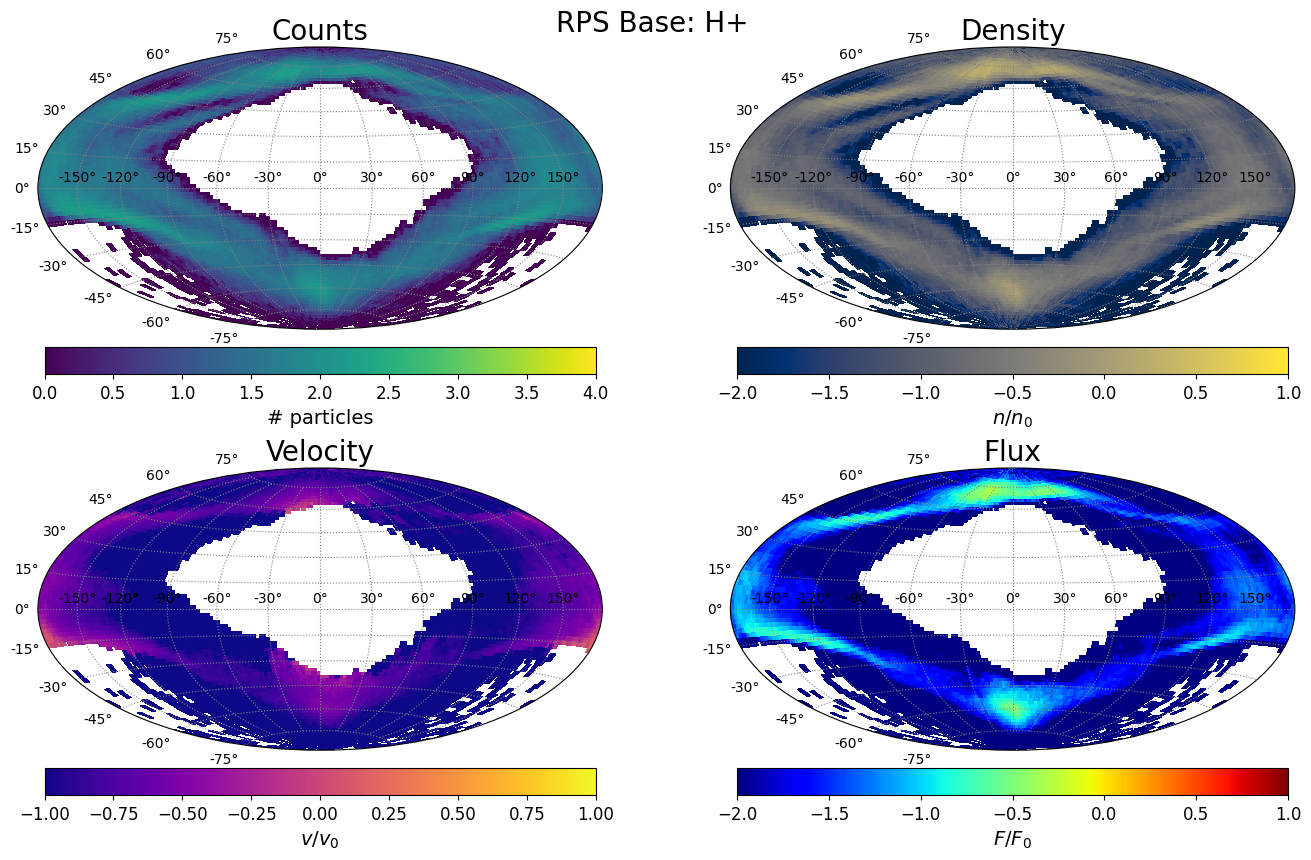

In [61]:
def safe_log10(arr, vmin=1e-30):
    out = np.full_like(arr, np.nan, dtype=float)
    mask = arr > vmin
    out[mask] = np.log10(arr[mask])
    return out

if "CP" in case:
    # Split north and south hemispheres
    df_north = df_footprints[df_footprints["hemisphere"] == "north"]
    df_south = df_footprints[df_footprints["hemisphere"] == "south"]

    # Convert to radians for Mollweide/Hammer projection
    lon_n_rad = np.deg2rad(df_north["longitude_deg"])
    lat_n_rad = np.deg2rad(df_north["ocb_latitude_deg"])

    lon_s_rad = np.deg2rad(df_south["longitude_deg"])
    lat_s_rad = np.deg2rad(df_south["ocb_latitude_deg"])

# -----------------------------
# Log-safe quantities
# -----------------------------
log_cnts = safe_log10(cnts)
log_den  = safe_log10(den / sim_den[specie_id])
log_vel  = safe_log10(velr / sim_vel[specie_id])
log_flx  = safe_log10(flxr / (sim_den[specie_id] * sim_vel[specie_id]))

# -----------------------------
# Grid (RADIANS for Hammer)
# -----------------------------
nlon, nlat = cnts.shape
lon = np.linspace(-np.pi, np.pi, nlon)
lat = np.linspace(-np.pi/2, np.pi/2, nlat)
lat = lat[::-1]  # flip latitude for plotting

# -----------------------------
# Plot setup
# -----------------------------
fig, axes = plt.subplots(
    2, 2, figsize=(14, 9),
    subplot_kw={"projection": "hammer"}
)

fig.patch.set_facecolor("white")
axes = axes.flatten()

fields = [
    (log_cnts, (0, 4),   "viridis", "# particles"),
    (log_den,  (-2, 1),  "cividis", r"$n/n_0$"),
    (log_vel,  (-1, 1),  "plasma",  r"$v/v_0$"),
    (log_flx,  (-2, 1),  "jet",     r"$F/F_0$")
]

titles = ["Counts", "Density", "Velocity", "Flux"]

for ax, (data, clim, cmap, cblabel), title in zip(axes, fields, titles):

    ax.set_facecolor("white")
    ax.grid(True, linestyle="dotted", color="gray")

    pcm = ax.pcolormesh(
        lon,
        lat,
        data.T,
        cmap=cmap,
        shading="auto"
    )
    pcm.set_clim(*clim)

    if "CP" in case:
        # Plot
        ax.plot(lon_n_rad, lat_n_rad, color="magenta", lw=2, label="OCB North")
        ax.plot(lon_s_rad, lat_s_rad, color="magenta", lw=2, ls="--", label="OCB South")

    cbar = plt.colorbar(pcm, ax=ax, orientation="horizontal", pad=0.05, shrink=0.85)
    cbar.set_label(cblabel, fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    ax.set_title(title, fontsize=20)

fig.suptitle(f"{case.replace("_", " ")}: {species[specie_id]}", fontsize=20, y=0.95)
plt.tight_layout()

if "CP" in case:
    outfile_png = os.path.join(output_folder, f"{case}_{species[specie_id]}_new_surface_flux_footprints.png")
else:
    outfile_png = os.path.join(output_folder, f"{case}_{species[specie_id]}_new_surface_flux.png")
plt.savefig(outfile_png, dpi=150, bbox_inches="tight")
print("Saved figure:", outfile_png)
plt.show()
